<div class="alert alert-block alert-info">
<b>Notice:</b> This companion notebook showcases the main features implemented in this repository and unravels code from other python files.
   
It illustrates: <li> the <a href=#train_py>training</a> of  GRSSL models,</li><li>how to assess models' <a href=#classification>classification capabilities</a></li><li> and possible <a href=#visualisation>visualisations of the embeddings</a></li>
</div>

In [1]:
from train import *

from Utils.tasks import *

%load_ext autoreload
%autoreload 2

/Users/nmm/miniforge3/envs/env_gdl/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#### check torch is using GPU:
print("torch.cuda.is_available(): {}".format(torch.cuda.is_available()))
print("torch.cuda.device_count(): {}".format(torch.cuda.device_count()))
if torch.cuda.is_available():
    print("torch.cuda.current_device(): {}".format(torch.cuda.current_device()))
    print("torch.cuda.device(0): {}".format(torch.cuda.device(0)))
    print("torch.cuda.get_device_name(0): {}".format(torch.cuda.get_device_name(0)))

torch.cuda.is_available(): False
torch.cuda.device_count(): 0


In [3]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cpu



**Table of Content:**
1. [Trainig GRSSL model](#train_py)
    1. [🧳 Data](#data)
    1. [🌻 Model](#model)
    5. [⚙️ Trainer](#trainer)
2. [Assess classification capabilities](#classification)
    1. [🟢 Netzschleuder dataset (from training)](#classification_netzschleuder)
    8. [🟣 TUDataset (conventional)](#classification_tudataset)
3. [Visualisation of the embeddings](#visualisation)
    
TODO:
- [x] visualising embeddings
- [ ] other assessment tasks

## 0. Parse Config file <a class="anchor" id="parsing"></a>

In [248]:
#CONFIG_PATH = "Configs/config_files/default_GCC_preMoCo.json"#default_GCC_preMoCo.json"
#CONFIG_PATH = "Configs/config_files/default_GCC_preMoCo_vGCN.json"#default_GCC_preMoCo.json"
#CONFIG_PATH = "Configs/config_files/config_graphmae_vGCN.json"#default_GCC_preMoCo_vGCN
#CONFIG_PATH = "Configs/config_files/config_graphmae_vGIN.json"
#CONFIG_PATH = "Configs/config_files/config_graphmae_vGAT.json"
CONFIG_PATH = "Configs/config_files/config_graphmae_repro.json"

#CONFIG_PATH = "Configs/config_files/config_PGCL_default.json"
#CONFIG_PATH = "Configs/config_files/config_PGCL_layers_4_dim_16.json"
#CONFIG_PATH = "Configs/config_files/config_PGCL_layers_4_dim_16_pedges.json"

config = ConfigParser.from_json(json_path = CONFIG_PATH)

In [249]:
config._inspected

False

In [250]:
# TEMPORARY: need to fix graph-tool import
#config._config["dataset"]["args"]["dgl_graphs"] = "REDDIT-BINARY"

In [251]:
config["arch"]["args"]

OrderedDict([('encoder_name', 'gcn'),
             ('encoder_args',
              OrderedDict([('num_layers', 4),
                           ('input_dimension', 512),
                           ('output_dimension', 64),
                           ('hidden_dimension', 64),
                           ('activation', 'relu'),
                           ('dropout', 0.0),
                           ('layernorm', False)])),
             ('decoder_name', 'gcn'),
             ('mask_rate', 0.5),
             ('drop_edge_rate', 0.0)])

---

# Training GRSSL model <a class="anchor" id="train_py"></a>

This section shows the process going on in `main` method from [`train.py`](./train.py).

## A. 🧳 Data <a class="anchor" id="data"></a>

### a) Load Dataset: `GraphDataset`

In [252]:
config["dataset"]

OrderedDict([('type', 'GraphMAEDataset'),
             ('args',
              OrderedDict([('dgl_graphs',
                            '../data/data_gnns/graphs_catalogue.csv'),
                           ('verbosity', True),
                           ('MAX_DEGREES', 511),
                           ('feature_dim', 512),
                           ('from_csv', True)]))])

In [253]:
dataset = config.init_obj('dataset', module_dataset)

🦦 converting 4489 graphs from graph-tool library to DGL format.


100%|████████████| 4489/4489 [12:58<00:00,  5.76it/s, graph=yeast_transcription]

The following graphs:
'['budapest_connectome/all_20k', 'budapest_connectome/female_20k', 'budapest_connectome/male_20k', 'budapest_connectome/male_200k', 'budapest_connectome/male_1m', 'dutch_criticism', 'gnutella/4', 'gnutella/6', 'gnutella/8', 'gnutella/9', 'hiv_transmission']'
... could not have been loaded from graph-tool library.


In [214]:
print(dataset)

┌-----------------------------------------------------------┐
|                       REDDIT-BINARY                       |
├-----------------------------------------------------------┤
|number of graphs                       |               2000|
|nodes — tot                            |             859254|
|nodes — mean                           |            429.627|
|nodes — median                         |              304.5|
|nodes — min                            |                  6|
|nodes — max                            |               3782|
|edges — tot                            |            1991016|
|edges — mean                           |            995.508|
|edges — median                         |              758.0|
|edges — min                            |                  8|
|edges — max                            |               8142|
|number of labels                       |                  2|
|   - 0 (0)                             |        1000 (50 %)|
|   - 1 

### b) Build data loader (`GraphDataLoader`)

In [215]:
config["data_loader"]

OrderedDict([('batch_size', 64),
             ('pin_memory', True),
             ('shuffle', False),
             ('sampler', 'SubsetRandomSampler'),
             ('collate_fn', 'collate_fn_graphmae')])

In [216]:
data_loader = dataset.make_GraphDataLoader(config["data_loader"])

In [217]:
#valid_data_loader = dataset.make_GraphDataLoader(config["data_loader"], validation=True)
valid_data_loader = None # no validation here

## B. 🌻 Model <a class="anchor" id="model"></a>

In [238]:
model = config.init_obj('arch', module_arch)

In [239]:
# prepare for (multi-device) GPU training
device, device_ids = prepare_device(config['n_gpu'])
model = model.to(device)
if len(device_ids) > 1:
    model = torch.nn.DataParallel(model, device_ids=device_ids)

In [240]:
print(model)

GraphMAEModel(
  (encoder): GAT(
    (layers): ModuleList(
      (0): GATConv(
        (fc): Linear(in_features=512, out_features=256, bias=False)
        (feat_drop): Dropout(p=0.0, inplace=False)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (leaky_relu): LeakyReLU(negative_slope=0.2)
        (activation): LeakyReLU(negative_slope=0.01)
      )
      (1): GATConv(
        (fc): Linear(in_features=128, out_features=256, bias=False)
        (feat_drop): Dropout(p=0.0, inplace=False)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (leaky_relu): LeakyReLU(negative_slope=0.2)
        (activation): LeakyReLU(negative_slope=0.01)
      )
      (2): GATConv(
        (fc): Linear(in_features=128, out_features=256, bias=False)
        (feat_drop): Dropout(p=0.0, inplace=False)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (leaky_relu): LeakyReLU(negative_slope=0.2)
        (activation): LeakyReLU(negative_slope=0.01)
      )
      (3): GATConv(
        (fc)

## C. ⚙️ Trainer <a class="anchor" id="trainer"></a>

In [241]:
criterion = config.init_obj('loss_type', module_loss)

In [242]:
metrics = None#[getattr(module_metric, met) for met in config['metrics']]

In [243]:
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = config.init_obj('optimizer', torch.optim, trainable_params)

In [244]:
lr_scheduler = config.init_obj('lr_scheduler', torch.optim.lr_scheduler, optimizer)

In [245]:
# 3.1 build trainer 
trainer_type = getattr(module_train, config['trainer_type']["type"])
trainer = trainer_type(model,
                       criterion,
                       metrics,
                       optimizer,
                       config=config,
                       device=device,
                       data_loader=data_loader,
                       valid_data_loader=valid_data_loader,
                       lr_scheduler=lr_scheduler,
                       **config['trainer_type']['args']
                      )

In [246]:
print("===========\nBEFORE TRAINING\n===========\n")

BEFORE TRAINING



In [247]:
%%time


test_classification = testmodel_dataset(
    model=trainer,
    dataset="REDDIT-BINARY", # --> loaded from trainer
    logger=None, # --> loaded from trainer
    seed=0,
    n_repeat=10,
    dummy_baselines=["most_frequent","uniform"],
)

GraphMAEModel(
  (encoder): GAT(
    (layers): ModuleList(
      (0): GATConv(
        (fc): Linear(in_features=512, out_features=256, bias=False)
        (feat_drop): Dropout(p=0.0, inplace=False)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (leaky_relu): LeakyReLU(negative_slope=0.2)
        (activation): LeakyReLU(negative_slope=0.01)
      )
      (1): GATConv(
        (fc): Linear(in_features=128, out_features=256, bias=False)
        (feat_drop): Dropout(p=0.0, inplace=False)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (leaky_relu): LeakyReLU(negative_slope=0.2)
        (activation): LeakyReLU(negative_slope=0.01)
      )
      (2): GATConv(
        (fc): Linear(in_features=128, out_features=256, bias=False)
        (feat_drop): Dropout(p=0.0, inplace=False)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (leaky_relu): LeakyReLU(negative_slope=0.2)
        (activation): LeakyReLU(negative_slope=0.01)
      )
      (3): GATConv(
        (fc)

In [163]:
TRAAIIIIIN

NameError: name 'TRAAIIIIIN' is not defined

In [183]:
%%capture --no-stdout --no-display 
# capture warnings for readibility of the output
# 3.2 🧞 train the model
training_time = time()
trainer.train()
training_time = time() - training_time

Saving checkpoint: saved/models/GraphMAE_default/0301_173021/untrained_model.pth ...
Train Epoch: 1 [0/32 (0%)] Loss: 1.009799
Train Epoch: 1 [8/32 (25%)] Loss: 0.926045
Train Epoch: 1 [16/32 (50%)] Loss: 0.756681


KeyboardInterrupt: 

In [184]:
%%time
print("===========\nAFTER TRAINING\n===========\n")

test_classification = testmodel_dataset(
    model=trainer,
    dataset="REDDIT-BINARY", # --> loaded from trainer
    logger=None, # --> loaded from trainer
    seed=0,
    n_repeat=10,
    dummy_baselines=["most_frequent","uniform"],
)

AFTER TRAINING

GraphMAEModel(
  (encoder): GIN(
    (layers): ModuleList(
      (0): GINLayer(
        (activation): PReLU(num_parameters=1)
        (mlp): MLP(
          (layers): ModuleList(
            (0): PLayer(
              in_features=512, out_features=256, bias=True
              (act): PReLU(num_parameters=1)
              (norm): Identity()
            )
            (1): PLayer(
              in_features=256, out_features=256, bias=True
              (act): Identity()
              (norm): Identity()
            )
          )
        )
        (apply_func): ApplyNodeFunc(
          (mlp): MLP(
            (layers): ModuleList(
              (0): PLayer(
                in_features=512, out_features=256, bias=True
                (act): PReLU(num_parameters=1)
                (norm): Identity()
              )
              (1): PLayer(
                in_features=256, out_features=256, bias=True
                (act): Identity()
                (norm): Identity()
         

KeyboardInterrupt: 

In [185]:
print(seconds2hms(training_time))

16:34:55


go back to [parsing ⬆️](#parsing)

---

# Assess classification capabilities <a class="anchor" id="classification"></a>

In [43]:
#from Models.model_util import *
from Utils.tasks import *

In [44]:
#from copy import deepcopy

## 🟢 Netzschleuder dataset (from training) <a class="anchor" id="classification_netzschleuder"></a>

In [45]:
%%time

test_classification = testmodel_dataset(
    model=trainer,
    dataset=None, # --> loaded from trainer
    logger=None, # --> loaded from trainer
    seed=0,
    n_repeat=10,
    dummy_baselines=["most_frequent","uniform"],
)

PGCLModel(
  (encoder): PGCLEncoder(
    (convs): ModuleList(
      (0): GINConv(nn=Sequential(
        (0): Linear(in_features=1, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_features=32, bias=True)
      ))
      (1): GINConv(nn=Sequential(
        (0): Linear(in_features=32, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_features=32, bias=True)
      ))
      (2): GINConv(nn=Sequential(
        (0): Linear(in_features=32, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_features=32, bias=True)
      ))
    )
    (bns): ModuleList(
      (0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (proj_head): Sequential(
      (0): Linear(in_features

/Users/nmm/Desktop/CMB_CSS_PDM/main_project/DL_module/Models/model_util.py:151: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = torch.tensor(batch, dtype=int)


	... embeddings computed in: 00:00:10.
10-folds SVC-Classification from embeddings ...
	... classification computed in: 00:00:19.
Computing dummy predictions: ['most_frequent', 'uniform'].
Scores:
	- Micro-F1 = 0.9596
	- Micro-F1 (std.) = 0.006809
	- most_frequent - micro-F1 = 0.3339
	- most_frequent - micro-F1 (std.) = 0.001292
	- uniform - micro-F1 = 0.1728
	- uniform - micro-F1 (std.) = 0.01754
CPU times: user 22.9 s, sys: 3.1 s, total: 26 s
Wall time: 30.5 s


## 🟣 TUDataset (conventional) <a class="anchor" id="classification_tudataset"></a>

In [24]:
%%time

test_classification_rdb = testmodel_dataset(
    model=trainer,
    dataset="REDDIT-BINARY", # --> loaded from trainer
    logger=None, # --> loaded from trainer
    seed=0,
    n_repeat=10,
    dummy_baselines=["most_frequent","uniform"],
)

GraphMAEModel(
  (encoder): GIN(
    (layers): ModuleList(
      (0): GINLayer(
        (activation): PReLU(num_parameters=1)
        (mlp): MLP(
          (layers): ModuleList(
            (0): PLayer(
              in_features=512, out_features=128, bias=True
              (act): PReLU(num_parameters=1)
              (norm): Identity()
            )
            (1): PLayer(
              in_features=128, out_features=128, bias=True
              (act): Identity()
              (norm): Identity()
            )
          )
        )
        (apply_func): ApplyNodeFunc(
          (mlp): MLP(
            (layers): ModuleList(
              (0): PLayer(
                in_features=512, out_features=128, bias=True
                (act): PReLU(num_parameters=1)
                (norm): Identity()
              )
              (1): PLayer(
                in_features=128, out_features=128, bias=True
                (act): Identity()
                (norm): Identity()
              )
         

In [43]:
tu_datasets_test = ["IMDB-BINARY", "IMDB-MULTI", "COLLAB", "PROTEINS", "REDDIT-BINARY", "DD"]

#tudata_name = "REDDIT-BINARY"

In [47]:
for tudata_name in tu_datasets_test:
    test_classification_tu = testmodel_dataset(
        model=trainer,
        dataset=tudata_name, # --> loaded from trainer
        logger=None, # --> loaded from trainer
        seed=0,
        n_repeat=10,
        dummy_baselines=["most_frequent","uniform"],
    )

PGCLModel(
  (encoder): PGCLEncoder(
    (convs): ModuleList(
      (0): GINConv(nn=Sequential(
        (0): Linear(in_features=1, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_features=32, bias=True)
      ))
      (1): GINConv(nn=Sequential(
        (0): Linear(in_features=32, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_features=32, bias=True)
      ))
      (2): GINConv(nn=Sequential(
        (0): Linear(in_features=32, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_features=32, bias=True)
      ))
    )
    (bns): ModuleList(
      (0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (proj_head): Sequential(
      (0): Linear(in_features

/Users/nmm/Desktop/CMB_CSS_PDM/main_project/DL_module/Models/model_util.py:151: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = torch.tensor(batch, dtype=int)


	... embeddings computed in: 00:00:00.
10-folds SVC-Classification from embeddings ...
	... classification computed in: 00:00:08.
Computing dummy predictions: ['most_frequent', 'uniform'].
Scores:
	- Micro-F1 = 0.713
	- Micro-F1 (std.) = 0.02571
	- most_frequent - micro-F1 = 0.5
	- most_frequent - micro-F1 (std.) = 0
	- uniform - micro-F1 = 0.503
	- uniform - micro-F1 (std.) = 0.03466
PGCLModel(
  (encoder): PGCLEncoder(
    (convs): ModuleList(
      (0): GINConv(nn=Sequential(
        (0): Linear(in_features=1, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_features=32, bias=True)
      ))
      (1): GINConv(nn=Sequential(
        (0): Linear(in_features=32, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_features=32, bias=True)
      ))
      (2): GINConv(nn=Sequential(
        (0): Linear(in_features=32, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_features=32

/Users/nmm/Desktop/CMB_CSS_PDM/main_project/DL_module/Models/model_util.py:151: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = torch.tensor(batch, dtype=int)


	... embeddings computed in: 00:00:01.
10-folds SVC-Classification from embeddings ...
	... classification computed in: 00:00:41.
Computing dummy predictions: ['most_frequent', 'uniform'].
Scores:
	- Micro-F1 = 0.4847
	- Micro-F1 (std.) = 0.03041
	- most_frequent - micro-F1 = 0.3333
	- most_frequent - micro-F1 (std.) = 5.551e-17
	- uniform - micro-F1 = 0.312
	- uniform - micro-F1 (std.) = 0.03474
PGCLModel(
  (encoder): PGCLEncoder(
    (convs): ModuleList(
      (0): GINConv(nn=Sequential(
        (0): Linear(in_features=1, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_features=32, bias=True)
      ))
      (1): GINConv(nn=Sequential(
        (0): Linear(in_features=32, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_features=32, bias=True)
      ))
      (2): GINConv(nn=Sequential(
        (0): Linear(in_features=32, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out

/Users/nmm/Desktop/CMB_CSS_PDM/main_project/DL_module/Models/model_util.py:151: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = torch.tensor(batch, dtype=int)


	... embeddings computed in: 00:00:05.
10-folds SVC-Classification from embeddings ...
	... classification computed in: 00:05:04.
Computing dummy predictions: ['most_frequent', 'uniform'].
Scores:
	- Micro-F1 = 0.7428
	- Micro-F1 (std.) = 0.01565
	- most_frequent - micro-F1 = 0.52
	- most_frequent - micro-F1 (std.) = 1.11e-16
	- uniform - micro-F1 = 0.3404
	- uniform - micro-F1 (std.) = 0.01965
PGCLModel(
  (encoder): PGCLEncoder(
    (convs): ModuleList(
      (0): GINConv(nn=Sequential(
        (0): Linear(in_features=1, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_features=32, bias=True)
      ))
      (1): GINConv(nn=Sequential(
        (0): Linear(in_features=32, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_features=32, bias=True)
      ))
      (2): GINConv(nn=Sequential(
        (0): Linear(in_features=32, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_f

/Users/nmm/Desktop/CMB_CSS_PDM/main_project/DL_module/Models/model_util.py:151: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = torch.tensor(batch, dtype=int)


	... embeddings computed in: 00:00:00.
10-folds SVC-Classification from embeddings ...
	... classification computed in: 00:00:03.
Computing dummy predictions: ['most_frequent', 'uniform'].
Scores:
	- Micro-F1 = 0.6954
	- Micro-F1 (std.) = 0.03829
	- most_frequent - micro-F1 = 0.5957
	- most_frequent - micro-F1 (std.) = 0.001659
	- uniform - micro-F1 = 0.5086
	- uniform - micro-F1 (std.) = 0.04567
PGCLModel(
  (encoder): PGCLEncoder(
    (convs): ModuleList(
      (0): GINConv(nn=Sequential(
        (0): Linear(in_features=1, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_features=32, bias=True)
      ))
      (1): GINConv(nn=Sequential(
        (0): Linear(in_features=32, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_features=32, bias=True)
      ))
      (2): GINConv(nn=Sequential(
        (0): Linear(in_features=32, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out

/Users/nmm/Desktop/CMB_CSS_PDM/main_project/DL_module/Models/model_util.py:151: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = torch.tensor(batch, dtype=int)


	... embeddings computed in: 00:00:01.
10-folds SVC-Classification from embeddings ...
	... classification computed in: 00:00:35.
Computing dummy predictions: ['most_frequent', 'uniform'].
Scores:
	- Micro-F1 = 0.9215
	- Micro-F1 (std.) = 0.01924
	- most_frequent - micro-F1 = 0.5
	- most_frequent - micro-F1 (std.) = 0
	- uniform - micro-F1 = 0.4755
	- uniform - micro-F1 (std.) = 0.02185
PGCLModel(
  (encoder): PGCLEncoder(
    (convs): ModuleList(
      (0): GINConv(nn=Sequential(
        (0): Linear(in_features=1, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_features=32, bias=True)
      ))
      (1): GINConv(nn=Sequential(
        (0): Linear(in_features=32, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_features=32, bias=True)
      ))
      (2): GINConv(nn=Sequential(
        (0): Linear(in_features=32, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_features=

/Users/nmm/Desktop/CMB_CSS_PDM/main_project/DL_module/Models/model_util.py:151: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = torch.tensor(batch, dtype=int)


	... embeddings computed in: 00:00:01.
10-folds SVC-Classification from embeddings ...
	... classification computed in: 00:00:05.
Computing dummy predictions: ['most_frequent', 'uniform'].
Scores:
	- Micro-F1 = 0.6706
	- Micro-F1 (std.) = 0.0182
	- most_frequent - micro-F1 = 0.5866
	- most_frequent - micro-F1 (std.) = 0.002961
	- uniform - micro-F1 = 0.5136
	- uniform - micro-F1 (std.) = 0.04403


In [44]:
for tudata_name in tu_datasets_test:
    test_classification_tu = testmodel_dataset(
        model=trainer,
        dataset=tudata_name, # --> loaded from trainer
        logger=None, # --> loaded from trainer
        seed=0,
        n_repeat=10,
        dummy_baselines=["most_frequent","uniform"],
    )

GraphMAEModel(
  (encoder): GCN(
    (layers): ModuleList(
      (0): GraphConv(
        in=512, out=256, normalization=both
        (_activation): ReLU()
      )
      (1): GraphConv(
        in=256, out=64, normalization=both
        (_activation): Identity()
      )
    )
  )
  (decoder): GRSSLModel(
    (encoder): GCN(
      (layers): ModuleList(
        (0): GraphConv(
          in=64, out=256, normalization=both
          (_activation): ReLU()
        )
        (1): GraphConv(
          in=256, out=512, normalization=both
          (_activation): Identity()
        )
      )
    )
  )
  (encoder_to_decoder): Linear(in_features=64, out_features=64, bias=False)
)
┌-----------------------------------------------------------┐
|                        IMDB-BINARY                        |
├-----------------------------------------------------------┤
|number of graphs                       |               1000|
|nodes — tot                            |              19773|
|nodes — mean 

In [53]:
test_classification_tu.print_scores(True)

Scores:
	- Micro-F1 = 0.7046
	- Micro-F1 (std.) = 0.03261
	- most_frequent - micro-F1 = 0.5866
	- most_frequent - micro-F1 (std.) = 0.002961
	- uniform - micro-F1 = 0.5093
	- uniform - micro-F1 (std.) = 0.04491


In [54]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE()

ys = test_classification_tu.labels
inds = np.arange(0,len(ys), 1)
np.random.shuffle(inds)

embs = tsne.fit_transform(test_classification_tu.embeddings)
x1s = embs[:,0]
x2s = embs[:,1]

ys, x1s, x2s = np.array(ys)[inds], np.array(x1s)[inds], np.array(x2s)[inds]

/Users/nmm/miniforge3/envs/env_gdl/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/nmm/miniforge3/envs/env_gdl/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


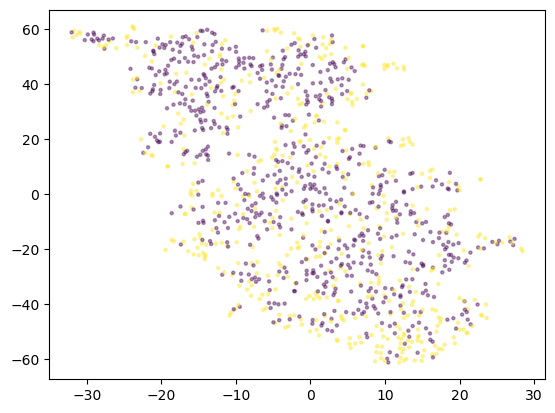

In [55]:
plt.scatter(x1s, x2s, c=ys, alpha=0.4, s=5)

---
# 🚧 Visualisation of the embeddings  <a class="anchor" id="visualisation"></a>

This section demonstrates the visualisation that can be plotted using the script implemented in [`viz.py`](./viz.py).

TODOs:

- [x] make visualizers from previous code
- [ ] make gallery

In [56]:
import viz as viz

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


GraphMAEModel(
  (encoder): GCN(
    (layers): ModuleList(
      (0): GraphConv(
        in=512, out=512, normalization=both
        (_activation): ReLU()
      )
      (1): GraphConv(
        in=512, out=32, normalization=both
        (_activation): Identity()
      )
    )
  )
  (decoder): GRSSLModel(
    (encoder): GCN(
      (layers): ModuleList(
        (0): GraphConv(
          in=32, out=512, normalization=both
          (_activation): ReLU()
        )
        (1): GraphConv(
          in=512, out=512, normalization=both
          (_activation): Identity()
        )
      )
    )
  )
  (encoder_to_decoder): Linear(in_features=32, out_features=32, bias=False)
)
┌------------------------------------------------------------┐
|           ../data/data_gnns/graphs_catalogue.csv           |
├------------------------------------------------------------┤
|number of graphs                       |                4478|
|nodes — tot                            |            10841827|
|nodes — 

/Users/nmm/miniforge3/envs/env_gdl/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/nmm/miniforge3/envs/env_gdl/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


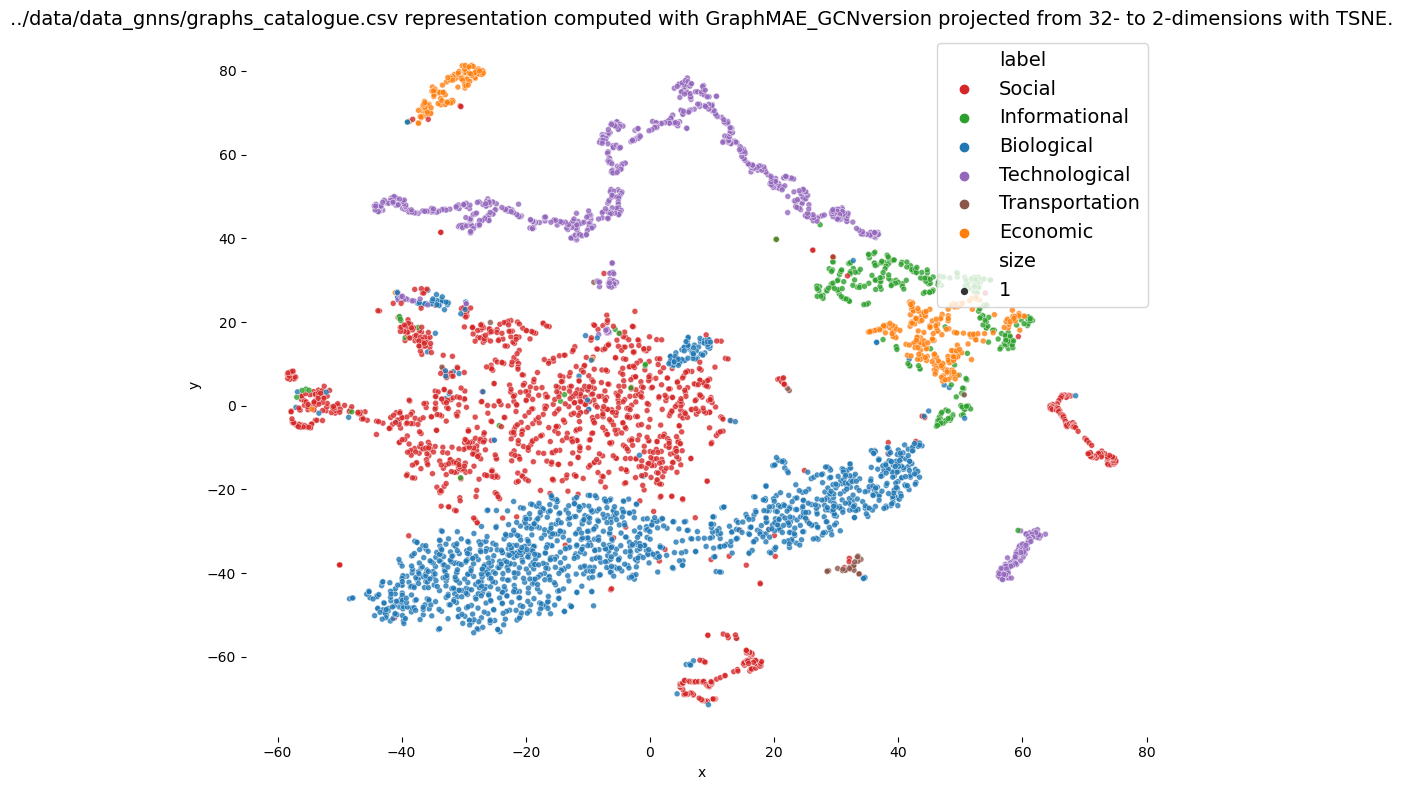

Dash app running on http://0.0.0.0:8060/


In [64]:
viz.main(
    model=trainer,
    #dataset="../data/data_gnns/graphs_catalogue.csv 64",
    model_name=trainer.config["name"],
    #pooler_args={},
    red_type="manifold.TSNE",#None
    #red_args={},
    no_interactive=False,
)

GraphMAEModel(
  (encoder): GCN(
    (layers): ModuleList(
      (0): GraphConv(
        in=512, out=512, normalization=both
        (_activation): ReLU()
      )
      (1): GraphConv(
        in=512, out=32, normalization=both
        (_activation): Identity()
      )
    )
  )
  (decoder): GRSSLModel(
    (encoder): GCN(
      (layers): ModuleList(
        (0): GraphConv(
          in=32, out=512, normalization=both
          (_activation): ReLU()
        )
        (1): GraphConv(
          in=512, out=512, normalization=both
          (_activation): Identity()
        )
      )
    )
  )
  (encoder_to_decoder): Linear(in_features=32, out_features=32, bias=False)
)
┌-----------------------------------------------------------┐
|                       REDDIT-BINARY                       |
├-----------------------------------------------------------┤
|number of graphs                       |               2000|
|nodes — tot                            |             859254|
|nodes — mean 

/Users/nmm/miniforge3/envs/env_gdl/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/nmm/miniforge3/envs/env_gdl/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


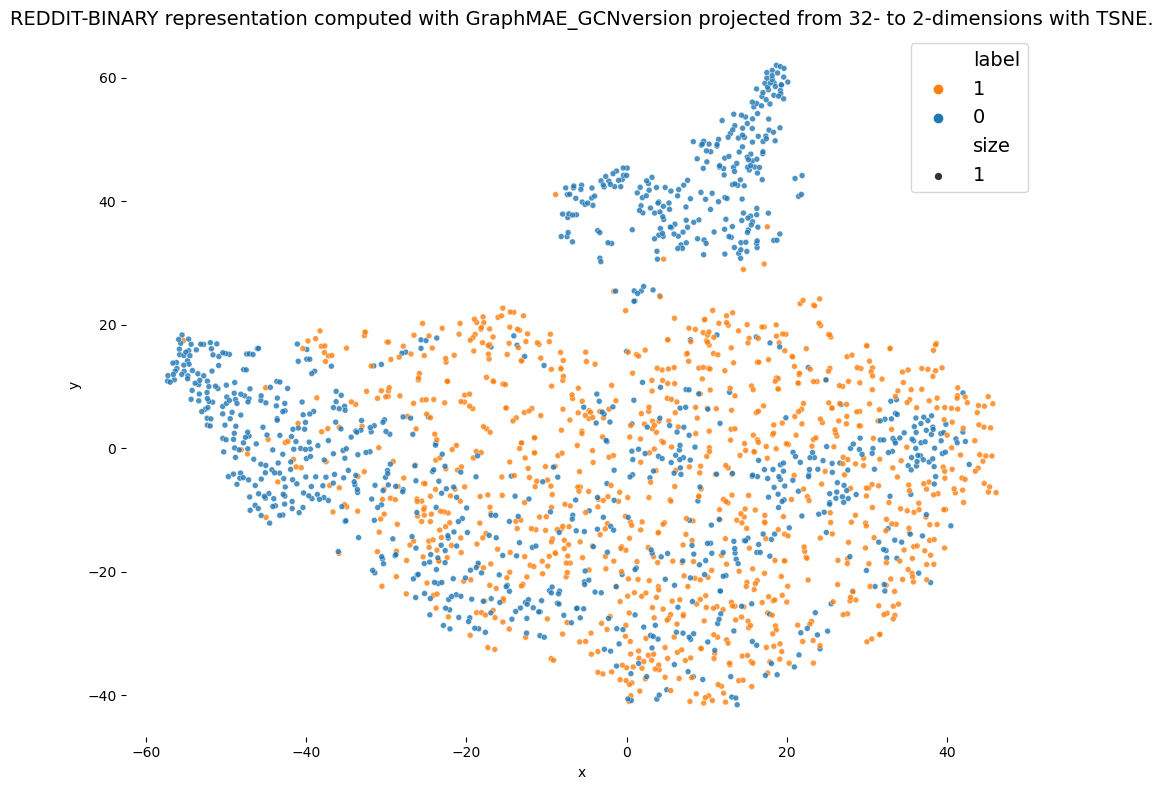

In [63]:
viz.main(
    model=trainer,
    dataset="REDDIT-BINARY",
    model_name=trainer.config["name"],
    #pooler_args={},
    red_type="manifold.TSNE",#None
    #red_args={},
    no_interactive=True,
)

In [33]:
import pandas as pd

In [34]:
csv_path, max_n = config["dataset"]["args"]["dgl_graphs"].split(" ")
graphs_data_df = pd.read_csv(csv_path)

graphs_names = graphs_data_df["Name"][:int(max_n)]
graphs_labels = graphs_data_df["Category"][:int(max_n)]

In [56]:
visualiser = viz.module_viz.GRVisualiser(
    graphs = graphs_names,
    embeddings = test_classification.embeddings,
    labels = graphs_labels,#test_classification.labels,
    og_format = "graph-tool",
    reducer_type = "decomposition.PCA"
)

NameError: name 'graphs_names' is not defined

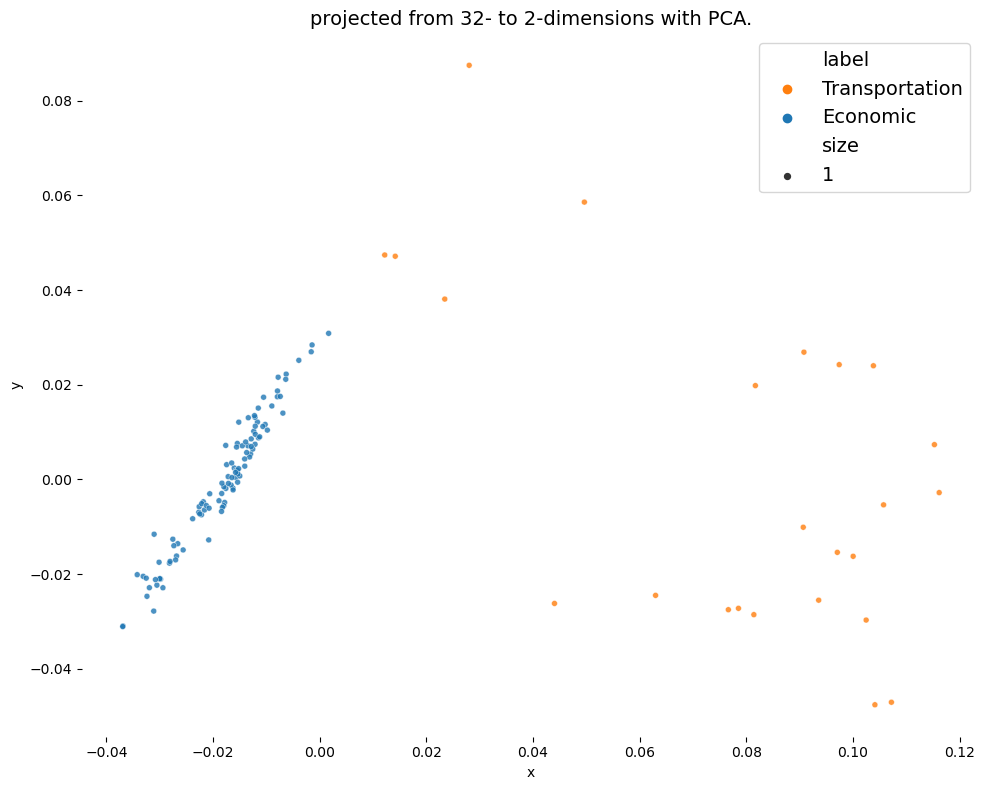

In [36]:
visualiser.show(
        static_args = viz._DEFAULT_STATIC_ARGS,
        interactive_args = viz._DEFAULT_INTERACT_ARGS
)

In [37]:
raise NotImplementedError("Stop Running Here")

NotImplementedError: Stop Running Here

### 🖌

In [55]:
app = visualiser.show_interactive(**viz._DEFAULT_INTERACT_ARGS)

app_host = "127.0.0.1"
app_port = "8060"

NameError: name 'visualiser' is not defined

In [ ]:
app.run_server("external"
               , port=app_port
               , debug=True
               , host=app_host
              )

In [ ]:
app.server#.session_interface

In [ ]:
import os
print(os.environ.get('DASH_DOMAIN_BASE', None))

In [ ]:
from urllib.request import Request, urlopen
BASE_URL = "http://{host}:{port}".format(host=app_host, port=app_port)
#SHUTDOWN = "/shutdown"
SHUTDOWN = "/_shutdown_{tok}".format(tok=app._token)

url = BASE_URL+SHUTDOWN

In [ ]:
url

In [ ]:
req = Request(url, method="POST")
res = urlopen(req)
content = res.read()
print(content)

In [ ]:
from flask import socketio2

In [ ]:
from flask import request

request.environ.get('werkzeug.server.shutdown')

In [ ]:
import multiprocessing
import multiprocess as mp

In [ ]:
def mp_run_server(**kwargs):
    app.run_server(**kwargs)
    return 

In [ ]:
p = mp.Process(target=mp_run_server,#app.run_server,
               name="Foo",
               kwargs={
                   "debug":True,
                   "mode":"external",
                   "port":"8060",
                   "host":"localhost",#"127.0.0.1"
               }
              )
#p.start()

In [ ]:
p.start()

In [ ]:
p.terminate()
p.join()

In [ ]:
shutdown_url = "http://{host}:{port}/_shutdown_{token}".format(
    host="127.0.0.1", port="8060", token=viz.module_viz.Dash._token
)

```python
@classmethod
    def _terminate_server_for_port(cls, host, port):
        shutdown_url = "http://{host}:{port}/_shutdown_{token}".format(
            host=host, port=port, token=JupyterDash._token
        )
        try:
            response = requests.get(shutdown_url)
        except Exception as e:
            pass
```

In [ ]:
shutdown_url = "http://{host}:{port}/_shutdown_{token}".format(
    host="localhost", port="8060", token=viz.module_viz.Dash._token
)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import PCA
import pandas as pd

from matplotlib import cm
import seaborn as sns

## 🖼 Representing the embedding space

In [ ]:
def scatter_embedding_visualizer(df:pd.DataFrame
                                 , x_col: str
                                 , y_col: str
                                 , size_attr: str
                                 , color_attr: str=None
                                 , cmap: str='viridis'
                                 , fig_dimensions:tuple = (25,15)
                                 , cat2color: dict=None
                                 , color_list: list=cm.get_cmap("tab10").colors
                                 , categorical_color:bool = False
                                ):

    categorical_color = type(df[color_attr][0])==str
    
    fig, ax = plt.subplots(figsize=fig_dimensions)
    
    if not categorical_color:
        plot = sns.scatterplot(
            x=df[x_col],
            y=df[y_col],
            hue=df[color_attr],
            palette=cm.get_cmap(cmap),
            size=df[size_attr],
            alpha=0.4,
        )
        
        # add colorbar
        norm = plt.Normalize(df[color_attr].min(), df[color_attr].max())
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])

        fig.colorbar(sm).outline.set_visible(False)
        
    else:
        
        if cat2color==None: 
            discrete_cats = sorted(df[color_attr].unique())
            cat2color= dict(zip(discrete_cats, color_list[:len(discrete_cats)]))
            
        plot = sns.scatterplot(
            x=df[x_col],
            y=df[y_col],
            hue=df[color_attr],
            palette=cat2color,
            size=df[size_attr],
            alpha=0.8,
        )
        
    # remove frame
    sns.despine(bottom = True, left = True)

    plot.legend(fontsize=14)
    plt.tight_layout()
    # show plot
    plt.show()
    
    return

In [ ]:
emb = TSNE(2)
#emb = PCA(2)
#emb = MDS(2, metric=False)

In [ ]:
#emb2d = emb.fit_transform(test_classification.embeddings)
emb2d = emb.fit_transform(test_classification_tu.embeddings)

In [ ]:
embx = [e[0] for e in emb2d]
emby = [e[1] for e in emb2d]

In [ ]:
embs = pd.DataFrame([embx, emby], ["x", "y"]).T
embs["size"] = 1
#embs["label"] = [dataset.labId_to_labName[lab] for lab in test_classification.labels]
embs["label"] = [str(lab) for lab in test_classification_tu.labels]

In [ ]:
scatter_embedding_visualizer(df=embs
                             , x_col="x"
                             , y_col="y"
                             , size_attr="size"
                             , color_attr="label"
                             #, cmap: str='viridis'
                             , fig_dimensions = (12, 12)
                             #, cat2color:=None
                             , color_list=list(cm.get_cmap("tab10").colors)
                             , categorical_color = True
                            )

## 🕹 Exploring the embedding space

# 🛠 Checking Classification: why are the scores so good ... ?

In [ ]:
tu_data = TUDataset("REDDIT-BINARY")

tu_graphs = tu_data.graph_lists
tu_labels = [int(lab[0]) for lab in tu_data.graph_labels]

In [ ]:
tu_dataset = module_dataset.GraphDataset(dgl_graphs = tu_graphs, graphs_labels = tu_labels)

In [ ]:
dummy_dim = 32

dummy_embs = np.array([np.random.random(dummy_dim) for _ in range(len(tu_dataset))])

In [ ]:
%%time
model.eval()
model_embs = np.array([model.embed(g) for g in tu_dataset])
model_embs = torch.cat([emb.detach().cpu() for emb in model_embs])

In [ ]:
shuffled_ids = [i for i, _ in enumerate(tu_dataset)]
np.random.shuffle(shuffled_ids)

In [ ]:
shuffled_graphs = [tu_graphs[idx] for idx in shuffled_ids]
shuffled_labels = [tu_labels[idx] for idx in shuffled_ids]
shuffled_dataset = module_dataset.GraphDataset(dgl_graphs = shuffled_graphs, graphs_labels = shuffled_labels)

shuffled_embs = model_embs[shuffled_ids]# for idx in shuffled_ids]

In [ ]:
checks_classification = GraphClassification(
    #dataset = tu_dataset,
    dataset = shuffled_dataset,
    #provided_embeddings = model_embs#dummy_embs
    provided_embeddings = shuffled_embs
)

In [ ]:
checks_classification.classification_scores()

In [ ]:
checks_classification.get_dummy_preds()

In [ ]:
checks_classification.print_scores()

# 🚧

In [ ]:
from Models import model_grssl
from DataLoader import data_loader
from DataLoader.data_util import *

from Trainers import trainer

%load_ext autoreload
%autoreload 2

In [ ]:
import DataLoader.data_loader as module_dataset
import Models.model_grssl as module_arch
import Trainers.loss as module_loss
import Trainers.trainer as module_train

from Utils.misc import prepare_device

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler

from dgl.dataloading import GraphDataLoader

In [ ]:
from Configs.configs_parser import *
import argparse

import collections

# 🔮 Prepare pipeline

In [ ]:
CONFIG_PATH = "Configs/config.json"

config = ConfigParser.from_json(json_path=CONFIG_PATH)

logger = config.get_logger('train')
logger.info("Config loaded from: '{}'.".format(CONFIG_PATH))

# load dataset and setup data_loader instances
logger.info("🌐 Loading Dataset...")
dataset = config.init_obj('dataset', module_dataset)
logger.info("Dataset loaded:\n{}".format(dataset))

data_loader = GraphDataLoader(
    dataset=dataset,
    **config["data_loader"]
)
valid_data_loader = None#data_loader.split_validation()

# build model architecture, then print to console
model = config.init_obj('arch', module_arch)
logger.info("🤖 Model instantiated:{name} ({l})\n{m}".format(name=model.model_name
                                                             , l=model.model_type
                                                             , m=model
                                                            )
           )

# prepare for (multi-device) GPU training
device, device_ids = prepare_device(config['n_gpu'])
model = model.to(device)
if len(device_ids) > 1:
    model = torch.nn.DataParallel(model, device_ids=device_ids)

# get function handles of loss and metrics
#criterion = getattr(module_loss, config['loss'])
criterion = config.init_obj('loss_type', module_loss)
metrics = None#[getattr(module_metric, met) for met in config['metrics']]

# build optimizer, learning rate scheduler. delete every lines containing lr_scheduler for disabling scheduler
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = config.init_obj('optimizer', torch.optim, trainable_params)
lr_scheduler = config.init_obj('lr_scheduler', torch.optim.lr_scheduler, optimizer)

In [ ]:
# get Trainer and build it
trainer_type = getattr(module_train, config['trainer_type']["type"])

In [ ]:
trainer = trainer_type(model,
                       criterion,
                       metrics,
                       optimizer,
                       config=config,
                       device=device,
                       data_loader=data_loader,
                       valid_data_loader=valid_data_loader,
                       lr_scheduler=lr_scheduler,
                       **config['trainer_type']['args']
                      )

In [ ]:
trainer.train()

# 🚇 Pipeline Tests

## 🔀 GCC

In [ ]:
pretext_keys = ["ceo_club", "bison", "copenhagen/calls"]
fake_labels = ["label2", "label1", "label2"]

### DataLoader

In [ ]:
test_gcc = data_loader.GCCDataset(dgl_graphs=graphtoolkeys2dglgraphs(pretext_keys)
                                  , graphs_labels=fake_labels
                                  , verbosity=True
                                 )

In [ ]:
test_gcc[0]

### Load config

In [ ]:
config = ConfigParser.from_json(json_path="Configs/config_gcc.json")

logger = config.get_logger('train')

# setup data_loader instances
data_loader = config.init_obj('data_loader', module_data)
#valid_data_loader = data_loader.split_validation()

# build model architecture, then print to console
model = config.init_obj('arch', module_arch)
logger.info(model)

# prepare for (multi-device) GPU training
device, device_ids = prepare_device(config['n_gpu'])
model = model.to(device)
if len(device_ids) > 1:
    model = torch.nn.DataParallel(model, device_ids=device_ids)

# get function handles of loss and metrics
#criterion = getattr(module_loss, config['loss'])
#metrics = [getattr(module_metric, met) for met in config['metrics']]

# build optimizer, learning rate scheduler. delete every lines containing lr_scheduler for disabling scheduler
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = config.init_obj('optimizer', torch.optim, trainable_params)
lr_scheduler = config.init_obj('lr_scheduler', torch.optim.lr_scheduler, optimizer)

In [ ]:
def batcher():
    def batcher_dev(batch):
        graph_q, graph_k = zip(*batch)
        graph_q, graph_k = dgl.batch(graph_q), dgl.batch(graph_k)
        return graph_q, graph_k

    return batcher_dev

def worker_init_fn(worker_id):
    worker_info = torch.utils.data.get_worker_info()
    dataset = worker_info.dataset
    dataset.graphs, _ = dgl.data.utils.load_graphs(
        dataset.dgl_graphs_file, dataset.jobs[worker_id]
    )
    dataset.length = sum([g.number_of_nodes() for g in dataset.graphs])
    np.random.seed(worker_info.seed % (2 ** 32))
    
gcc_graph_loader = GraphDataLoader(
     dataset=config["data_loader"],#gtdata,
    batch_size=16,
    collate_fn=labeled_batcher() if False else batcher(),
    shuffle=True if False else False,
    num_workers=0,
    worker_init_fn=None if False or False else worker_init_fn,
)

In [ ]:
train_loader = torch.utils.data.DataLoader(
    dataset=config["data_loader"],#gtdata,
    batch_size=16,
    collate_fn=labeled_batcher() if False else batcher(),
    shuffle=True if False else False,
    num_workers=0,
    worker_init_fn=None if False or False else worker_init_fn,
)

In [ ]:
gcc_trainer = trainer.GCCTrainer(
    model=graphmae_model,
    criterion=None,
    metric_ftns=None,
    optimizer=optimizer,
    config= config,#{"trainer":{"epochs":2,
                  #      "save_period":1,
                  #      "monitor":"min",
                  #     }
            #},
    device='cpu',
    data_loader=gcc_graph_loader, #  XXX
    valid_data_loader=None,
    lr_scheduler=None,
    len_epoch=None,
    alpha_moco=0.01,
)

In [ ]:
gcc_trainer.train()

### Model

In [ ]:
gin_args = {
    'num_layers':4,
    'input_dimension':65,
    'output_dimension':16,
    'hidden_dimension':64
}

In [ ]:
gcc_model = model_grssl.GCCModel(encoder_args=gin_args, norm=True)

In [ ]:
gcc_model.degree_input

In [ ]:
test_gcc.graphs

In [ ]:
gcc_model.encoder.input_dimension

In [ ]:
gcc_model(test_gcc[0][0]).shape

### Trainer

## 🎭 GraphMAE

### DataLoader

In [ ]:
pretext_keys = ["ceo_club", "bison", "copenhagen/calls"]
fake_labels = ["label2", "label1", "label2"]

test_mae = data_loader.GraphMAEDataset(pretext_keys#dgl_graphs=graphtoolkeys2dglgraphs(pretext_keys)
                                  , graphs_labels=fake_labels
                                  , verbosity=True
                                 )

In [ ]:
batch_size=32

train_idx = torch.arange(len(test_mae))
train_sampler = SubsetRandomSampler(train_idx)

test_train_loader = GraphDataLoader(test_mae
                                    #, sampler=train_sampler
                                    #, collate_fn=collate_fn
                                    , batch_size=batch_size
                                    , pin_memory=True
                                   )

In [ ]:
test_mae[0][0].ndata["attr"].shape

### Model

In [ ]:
gin_args = {
    'num_layers':4,
    'input_dimension':22,
    'output_dimension':16,
    'hidden_dimension':64
}

graphmae_model = model_grssl.GraphMAEModel(encoder_args=gin_args, drop_rate=0.01)

In [ ]:
graphmae_model(test_mae[0][0], test_mae[0][0].ndata["attr"])

In [ ]:
graphmae_model.encoder_to_decoder

In [ ]:
test_mae[0][0]

### Load Config

In [ ]:
from Configs.configs_parser import *
import argparse

import collections

In [ ]:
config = ConfigParser.from_json(json_path="Configs/config.json")

logger = config.get_logger('train')

# setup data_loader instances
data_loader = config.init_obj('data_loader', module_data)
#valid_data_loader = data_loader.split_validation()

# build model architecture, then print to console
model = config.init_obj('arch', module_arch)
logger.info(model)

# prepare for (multi-device) GPU training
device, device_ids = prepare_device(config['n_gpu'])
model = model.to(device)
if len(device_ids) > 1:
    model = torch.nn.DataParallel(model, device_ids=device_ids)

# get function handles of loss and metrics
#criterion = getattr(module_loss, config['loss'])
#metrics = [getattr(module_metric, met) for met in config['metrics']]

# build optimizer, learning rate scheduler. delete every lines containing lr_scheduler for disabling scheduler
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = config.init_obj('optimizer', torch.optim, trainable_params)
lr_scheduler = config.init_obj('lr_scheduler', torch.optim.lr_scheduler, optimizer)

### Trainer

In [ ]:
config["optimizer"]

In [ ]:
mae_trainer = trainer.GraphMAETrainer(
    model=graphmae_model,
    criterion=None,
    metric_ftns=None,
    optimizer=optimizer,
    config= config,#{"trainer":{"epochs":2,
                  #      "save_period":1,
                  #      "monitor":"min",
                  #     }
            #},
    device='cpu',
    data_loader=test_train_loader,
    valid_data_loader=None,
    lr_scheduler=None,
    len_epoch=None,
)

In [ ]:
mae_trainer.train()